In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.impute import SimpleImputer
from prophet import Prophet

In [ ]:
# Load the data
df = pd.read_csv('/content/LemonPrices.csv')
df.head()

,Market,Date,Arrivals (Tonnes),Variety,Modal Price(Rs./Quintal),State,Year,Month
0,Gopalavaram,01-01-2022,21.4,V1,1500.0,ANP,2022.0,1.0
1,Tenali,01-01-2022,15.0,V1,1800.0,ANP,2022.0,1.0
2,Durg,01-01-2022,1.8,V1,3800.0,CHH,2022.0,1.0
3,Rajnandgaon,01-01-2022,1.0,V1,2000.0,CHH,2022.0,1.0
4,Ahmedabad,01-01-2022,37.7,Other,1650.0,GUJ,2022.0,1.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157834 entries, 0 to 157833
Data columns (total 8 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Market                    157832 non-null  object 
 1   Date                      157829 non-null  object 
 2   Arrivals (Tonnes)         157831 non-null  float64
 3   Variety                   157728 non-null  object 
 4   Modal Price(Rs./Quintal)  157832 non-null  float64
 5   State                     157832 non-null  object 
 6   Year                      157832 non-null  float64
 7   Month                     157832 non-null  float64
dtypes: float64(4), object(4)
memory usage: 9.6+ MB


In [ ]:
# Check for missing values
missing_summary = df.isnull().sum()

In [ ]:
print(df.columns)

Index(['Market', 'Date', 'Arrivals (Tonnes)', 'Variety',
       'Modal Price(Rs./Quintal)', 'State', 'Year', 'Month'],
      dtype='object')


In [ ]:
# Rename columns for simplicity
df.rename(columns={
    'Date': 'date',
    'Arrivals (Tonnes)': 'arrivals',
    'Modal Price(Rs./Quintal)': 'price',
    'State': 'state'
}, inplace=True)

In [ ]:
df['date'] = pd.to_datetime(df['date'], dayfirst=True)
print(df['date'].head())

0   2022-01-01
1   2022-01-01
2   2022-01-01
3   2022-01-01
4   2022-01-01
Name: date, dtype: datetime64[ns]


In [ ]:
# Check for duplicates
duplicates = df.duplicated().sum()

In [ ]:
# Look for rows where:
# Price exists but quantity is missing OR vice versa
anomalies_price_only = df[(df['price'].notna()) & (df['arrivals'].isna())]
anomalies_arrivals_only = df[(df['arrivals'].notna()) & (df['price'].isna())]

In [ ]:
from scipy.stats import zscore

df['price_z'] = zscore(df['price'].fillna(0))
df['arrivals_z'] = zscore(df['arrivals'].fillna(0))

In [ ]:
# Mark price outliers
price_outliers = df[np.abs(df['price_z']) > 3]
arrival_outliers = df[np.abs(df['arrivals_z']) > 3]

In [ ]:
# Group by month and visualize average prices
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

Text(0, 0.5, 'Avg Price')

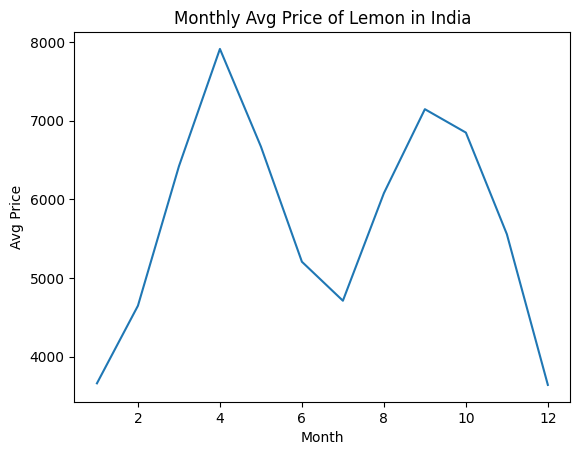

In [ ]:
monthly_avg = df.groupby('month')['price'].mean()
sns.lineplot(x=monthly_avg.index, y=monthly_avg.values)
plt.title('Monthly Avg Price of Lemon in India')
plt.xlabel('Month'); plt.ylabel('Avg Price')

In [ ]:
# Remove outliers before this step
clean_df = df[(np.abs(df['price_z']) < 3) & (np.abs(df['arrivals_z']) < 3)]

# Monthly & Yearly avg prices
monthly_all = clean_df.groupby(['year', 'month'])['price'].mean().reset_index()
monthly_state = clean_df.groupby(['state', 'year', 'month'])['price'].mean().reset_index()

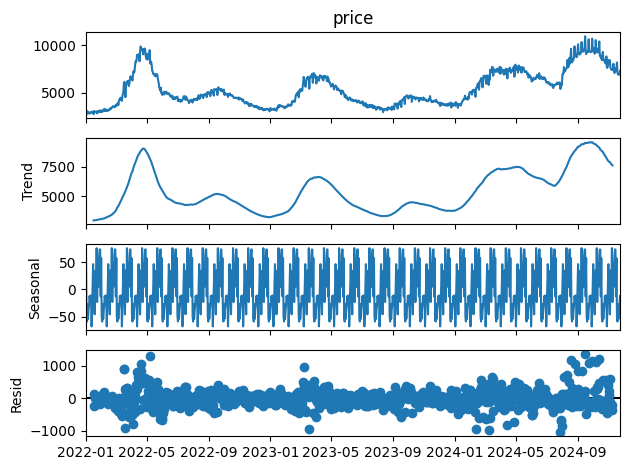

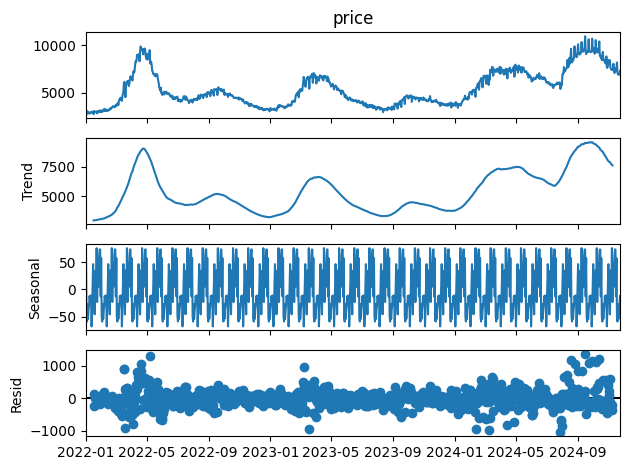

In [ ]:
# Aggregate daily prices to monthly for decomposition
monthly_series = clean_df.groupby('date')['price'].mean().asfreq('D')

# Fill missing with interpolation
monthly_series = monthly_series.interpolate()

# Decompose
decomp = seasonal_decompose(monthly_series, model='additive', period=30)
decomp.plot()

In [ ]:
# Prepare for Prophet
prophet_df = clean_df.groupby('date')['price'].mean().reset_index()
prophet_df.columns = ['ds', 'y']

In [ ]:
model = Prophet()
model.fit(prophet_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmptf_vofyk/kl8ul9w4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptf_vofyk/r37yixo_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95750', 'data', 'file=/tmp/tmptf_vofyk/kl8ul9w4.json', 'init=/tmp/tmptf_vofyk/r37yixo_.json', 'output', 'file=/tmp/tmptf_vofyk/prophet_modelop7gag4r/prophet_model-20250731162512.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:25:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:25:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


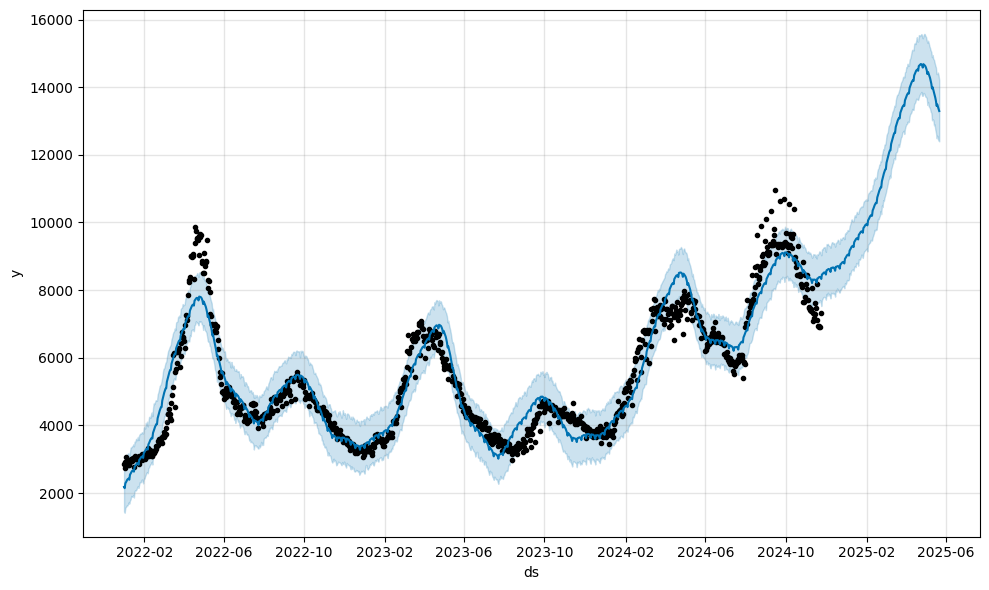

In [ ]:
# Predict next 180 days (~2 quarters)
future = model.make_future_dataframe(periods=180)
forecast = model.predict(future)

# Plot
fig = model.plot(forecast)